# Example

The following example demonstrates how to the use the `pymatch` package to match [Lending Club Loan Data](https://www.kaggle.com/datasets/imsparsh/lending-club-loan-dataset-2007-2011). Follow the link to download the dataset from Kaggle (you'll have to create an account, it's fast and free!).

Lending Club是最大的在线贷款市场，提供个人贷款、商业贷款和医疗程序融资。借款人可以通过快速的在线界面轻松获得较低利率的贷款。

这些文件包含 2007 年至 2011 年发放的所有贷款的完整贷款数据，包括当前贷款状态（当前、已注销、已全额支付等）和最新付款信息。包含截至“现在”的贷款数据的文件包含截至上一个完整日历季度发放的所有贷款的完整贷款数据。其他功能包括信用评分、财务查询次数和收款等。该文件是一个包含约 39,000 个观测值和 111 个变量的矩阵。数据字典在单独的文件中提供。


Here we match Lending Club users that fully paid off loans (control) to those that defaulted (test). The example is contrived, however a use case for this could be that we want to analyze user sentiment with the platform. Users that default on loans may have worse sentiment because they are predisposed to a bad situation--influencing their perception of the product. Before analyzing sentiment, we can match users that paid their loans in full to users that defaulted based on the characteristics we can observe. If matching is successful, we could then make a statetment about the **causal effect** defaulting has on sentiment if we are confident our samples are sufficiently balanced and our model is free from omitted variable bias.

在这里，我们将完全还清贷款的 Lending Club 用户（对照组）与违约用户（测试组）进行匹配。
这个例子是人为的，但是一个用例可能是我们想要分析平台上的用户情绪。
违约贷款的用户可能会有更糟糕的情绪，因为他们容易陷入糟糕的境地——这会影响他们对产品的看法。
在分析情绪之前，我们可以根据我们观察到的特征将全额偿还贷款的用户与违约用户进行匹配。
如果匹配成功，我们就可以对违约对情绪的因果影响做出陈述，前提是我们相信我们的样本足够平衡，并且我们的模型没有遗漏变量偏差。

This example, however, only goes through the matching procedure, which can be broken down into the following steps:

* [Data Preparation](#Data-Prep)
* [Fit Propensity Score Models](#Matcher)
* [Predict Propensity Scores](#Predict-Scores)
* [Tune Threshold](#Tune-Threshold)
* [Match Data](#Match-Data)
* [Assess Matches](#Assess-Matches)

----

### Data Prep

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from psmatch.Matcher import Matcher
import pandas as pd
import numpy as np

Load the dataset (`loan.csv`), which is the original `loan.csv` sampled as follows:

```python
path = 'misc/loan_full.csv'
fields = [
    "loan_amnt",
    "funded_amnt",
    "funded_amnt_inv",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",
    "loan_status"
]
data = pd.read_csv(path)[fields]

# Treat long late as Defaulted
data.loc[data['loan_status'] == 'Late (31-120 days)', 'loan_status'] = 'Default'

# Sample 20K records from Fully paid and 2K from default
df = data[data.loan_status == 'Fully Paid'].sample(20000, random_state=42) \
    .append(data[data.loan_status == 'Default'].sample(2000, random_state=42))

df.to_csv('misc/loan.csv', index=False)
```

loan_amnt 贷款金额： 借款人申请的贷款金额。如果在某个时间点信用部门减少了贷款金额，则该值会反映出来。

funded_amnt 贷款金额：在那个时间点上对应贷款的承诺总金额。

funded_amnt_inv 投资者已出资金额：在那个时间点上投资者为该贷款承诺的总金额。

grade 贷款评级：LC分配的贷款等级。

sub_grade LC 分配的贷款子等级

installment 借款人每月应偿还的付款额（如果贷款开始）。

int_rate 贷款利率。

term	The number of payments on the loan. Values are in months and can be either 36 or 60.

干预点

loan_status 贷款状态： 当前贷款的状态


In [2]:
path = "misc/loan.csv"
data = pd.read_csv(path)

Create test and control groups and reassign `loan_status` to be a binary treatment indicator. This is our reponse in the logistic regression model(s) used to generate propensity scores.

In [3]:
test = data[data.loan_status == "Default"]
control = data[data.loan_status == "Fully Paid"]
test['loan_status'] = 1
control['loan_status'] = 0

----

### `Matcher`

Initalize the `Matcher` object. 

**Note that:**

* Upon intialization, `Matcher` prints the formula used to fit logistic regression model(s) and the number of records in the majority/minority class. 
    * The regression model(s) are used to generate propensity scores. In this case, we are using the covariates on the right side of the equation to estimate the probability of defaulting on a loan (`loan_status`= 1). 
* `Matcher` will use all covariates in the dataset unless a formula is specified by the user. Note that this step is only fitting model(s), we assign propensity scores later. 
* Any covariates passed to the (optional) `exclude` parameter will be ignored from the model fitting process. This parameter is particularly useful for unique identifiers like a `user_id`. 

In [4]:
m = Matcher(test, control, yvar="loan_status", exclude=[])

Formula:
loan_status ~ funded_amnt+funded_amnt_inv+grade+installment+int_rate+loan_amnt+sub_grade+term
1 0
n majority: 20000
n minority: 2000


There is a significant imbalance in our data--the majority group (fully-paid loans) having many more records than the minority group (defaulted loans). We account for this by setting `balance=True` when calling `Matcher.fit_scores()` below. This tells `Matcher` to sample from the majority group when fitting the logistic regression model(s) so that the groups are of equal size. When undersampling this way, it is highly recommended that `nmodels` is explictly assigned to a integer much larger than 1. This ensure is that more of the majority group is contributing to the generation of propensity scores. The value of this integer should depend on the severity of the imbalance; here we use `nmodels`=100.

In [237]:
# for reproducibility
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=10)

This computer has: 12 cores , The workers should be :1
Fitting Models on Balanced Samples , model number :0
Fitting Models on Balanced Samples , model number :1
Fitting Models on Balanced Samples , model number :2
Fitting Models on Balanced Samples , model number :3
Fitting Models on Balanced Samples , model number :4
Fitting Models on Balanced Samples , model number :5
Fitting Models on Balanced Samples , model number :6
Fitting Models on Balanced Samples , model number :7
Fitting Models on Balanced Samples , model number :8
Fitting Models on Balanced Samples , model number :9

Average Accuracy: 65.4%


The average accuracy of our 100 models is 66.06%, suggesting that there's separability within our data and justifiying the need for the matching procedure. It's worth noting that we don't pay much attention to these logistic models since we are using them as a feature extraction tool (generation of propensity scores). The accuracy is a good way to detect separability at a glance, but we shouldn't spend time tuning and tinkering with these models. If our accuracy was close to 50%, that would suggest we cannot detect much separability in our groups given the features we observe and that matching is probably not necessary (or more features should be included if possible).

In [224]:
np.random.seed(20210419)

# m.fit_scores(balance=True, nmodels=10,n_jobs = 12,model_type='tree')

This computer has: 12 cores , The workers should be :12
Fitting Models on Balanced Samples , model number :0
Fitting Models on Balanced Samples , model number :1
Fitting Models on Balanced Samples , model number :2
Fitting Models on Balanced Samples , model number :3
Fitting Models on Balanced Samples , model number :4
Fitting Models on Balanced Samples , model number :5
Fitting Models on Balanced Samples , model number :6
Fitting Models on Balanced Samples , model number :7
Fitting Models on Balanced Samples , model number :8
Fitting Models on Balanced Samples , model number :9

Average Accuracy: 73.75%


### Predict Scores

In [238]:
m.predict_scores()

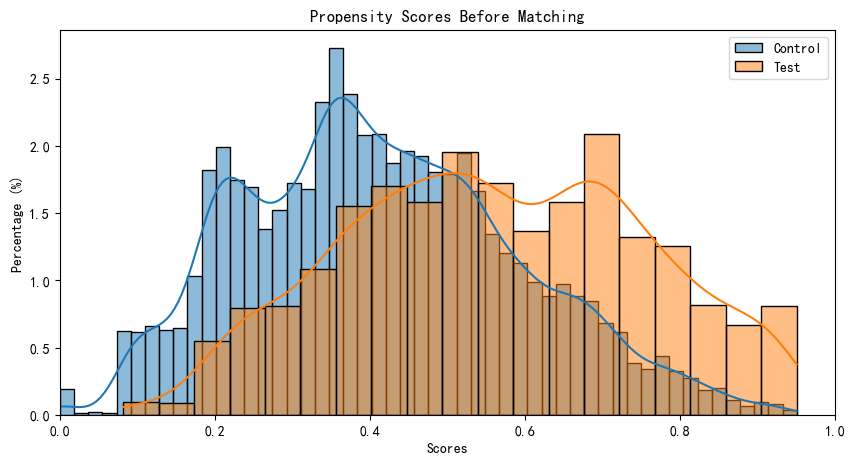

In [239]:
m.plot_scores()

The plot above demonstrates the separability present in our data. Test profiles have a much higher **propensity**, or estimated probability of defaulting given the features we isolated in the data.

---

### Tune Threshold

The `Matcher.match()` method matches profiles that have propensity scores within some threshold. 

i.e. for two scores `s1` and `s2`, `|s1 - s2|` <= `threshold`

By default matches are found *from* the majority group *for* the minority group. For example, if our test group contains 1,000 records and our control group contains 20,000, `Matcher` will
    iterate through the test (minority) group and find suitable matches from the control (majority) group. If a record in the minority group has no suitable matches, it is dropped from the final matched dataset. We need to ensure our threshold is small enough such that we get close matches and retain most (or all) of our data in the minority group.
    
Below we tune the threshold using `method="random"`. This matches a random profile that is within the threshold
as there could be many. This is much faster than the alternative method "min", which finds the *closest* match for every minority record.

0 / 10 - 0.0 finished 0.4095
1 / 10 - 0.0001 finished 0.906
2 / 10 - 0.0002 finished 0.9585
3 / 10 - 0.00030000000000000003 finished 0.9705
4 / 10 - 0.0004 finished 0.9795
5 / 10 - 0.0005 finished 0.983
6 / 10 - 0.0006000000000000001 finished 0.984
7 / 10 - 0.0007 finished 0.9895
8 / 10 - 0.0008 finished 0.992
9 / 10 - 0.0009000000000000001 finished 0.9935


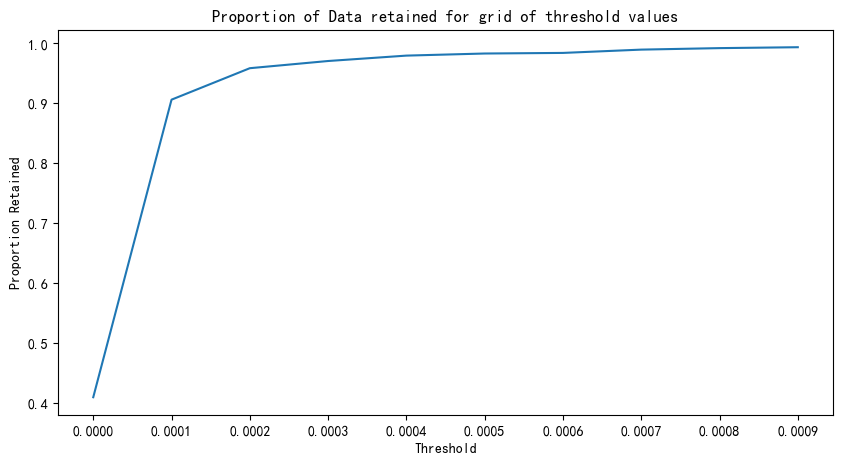

In [240]:
m.tune_threshold(method='random')

It looks like a threshold of 0.0005 retains enough information in our data. Let's proceed with matching using this threshold.

---

### Match Data

Below we match one record from the majority group to each record in the minority group. This is done **with** replacement, meaning a single majority record can be matched to multiple minority records. `Matcher` assigns a unique `record_id` to each record in the test and control groups so this can be addressed after matching. If susequent modelling is planned, one might consider weighting models using a weight vector of 1/`f` for each record, `f` being a record's frequency in the matched dataset. Thankfully `Matcher` can handle all of this for you :).

In [312]:
# m.match(method="min", nmatches=1, threshold=0.0005)
# m.match(method="random", nmatches=1, threshold=0.01)
# 基本上都能通过p值检验
# m.match(method="random", nmatches=1, threshold=0.00099)
m.match(method="random", nmatches=1, threshold=0.0001)

# 连续值基本上都通不过
# m.match(method="random", nmatches=1, threshold=0.005)
# 连续值基本上都通不过
# m.match(method="random", nmatches=1, threshold=0.003)

# 基本上都能通过p值检验 - 接近
# m.match(method="random", nmatches=1, threshold=0.0009)

# 基本上都能通过p值检验-基本上不能
# m.match(method="random", nmatches=1, threshold=0.0015)

# m.match(method="min", nmatches=1, threshold=0.005)

# 最小匹配,居然不如随机匹配
# m.match(method="min", nmatches=1, threshold=0.001)

In [313]:
m.record_frequency()

,freq,n_records
0,1,3265
1,2,151
2,3,15
3,4,3


It looks like the bulk of our matched-majority-group records occur only once, 68 occur twice, ... etc. We can preemptively generate a weight vector using `Matcher.assign_weight_vector()`

In [314]:
m.assign_weight_vector()

Let's take a look at our matched data thus far. Note that in addition to the weight vector, `Matcher` has also assigned a `match_id` to each record indicating our (in this cased) *paired* matches since we use `nmatches=1`. We can verify that matched records have `scores` within 0.0001 of each other. 

In [315]:
m.matched_data.sort_values("match_id").head(20)

,record_id,matched_count,funded_amnt,funded_amnt_inv,grade,installment,int_rate,loan_amnt,loan_status,sub_grade,term,scores,match_id,weight
0,0,1,12000,12000.0,C,270.53,12.59,12000,1,C2,60 months,0.503974,0,1.000000
2336,8071,1,20000,19750.0,B,680.36,13.67,20000,0,B5,36 months,0.503979,0,1.000000
1843,2288,1,15000,15000.0,B,489.31,10.75,15000,0,B4,36 months,0.322852,1,1.000000
1,1,1,15000,15000.0,B,489.31,10.75,15000,1,B4,36 months,0.322852,1,1.000000
3316,18613,1,7800,7800.0,B,255.33,10.99,7800,0,B4,36 months,0.311973,2,1.000000
2,2,1,30000,30000.0,A,919.34,6.49,30000,1,A2,36 months,0.312008,2,1.000000
3,3,1,7500,7500.0,C,264.20,16.14,7500,1,C4,36 months,0.651618,3,1.000000
2931,14514,1,11200,11200.0,D,284.35,17.99,11200,0,D2,60 months,0.651695,3,1.000000
4,4,1,26125,26125.0,C,893.28,14.03,26125,1,C2,36 months,0.574329,4,1.000000
2415,9133,1,22500,22500.0,E,614.80,21.48,22500,0,E5,60 months,0.574270,4,1.000000


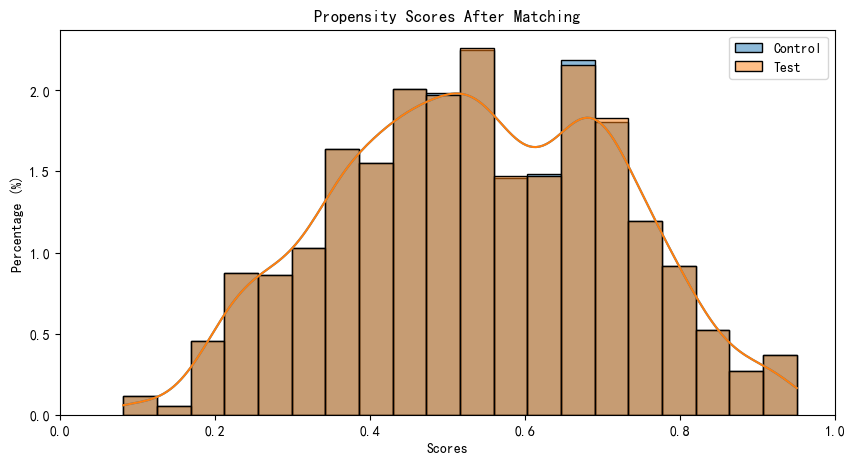

In [316]:
# 匹配后的倾向性得分直方图
m.plot_scores('after')

---

### Assess Matches

We must now determine if our data is "balanced". Can we detect any statistical differences between the covariates of our matched test and control groups? `Matcher` is configured to treat categorical and continouous variables separately in this assessment.

___Discrete___

For categorical variables, we look at plots comparing the proportional differences between test and control before and after matching. 

For example, the first plot shows:
* `prop_test` - `prop_control` for all possible `term` values---`prop_test` and `prop_control` being the proportion of test and control records with a given term value, respectively. We want these (orange) bars to be small after matching.
* Results (pvalue) of a Chi-Square Test for Independence before and after matching. After matching we want this pvalue to be > 0.05, resulting in our failure to reject the null hypothesis that the frequecy of the enumerated term values are independent of our test and control groups.

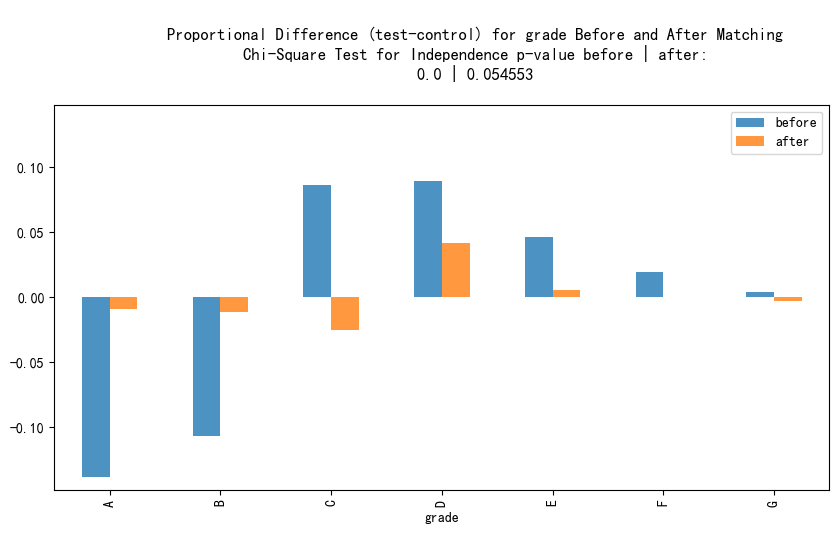

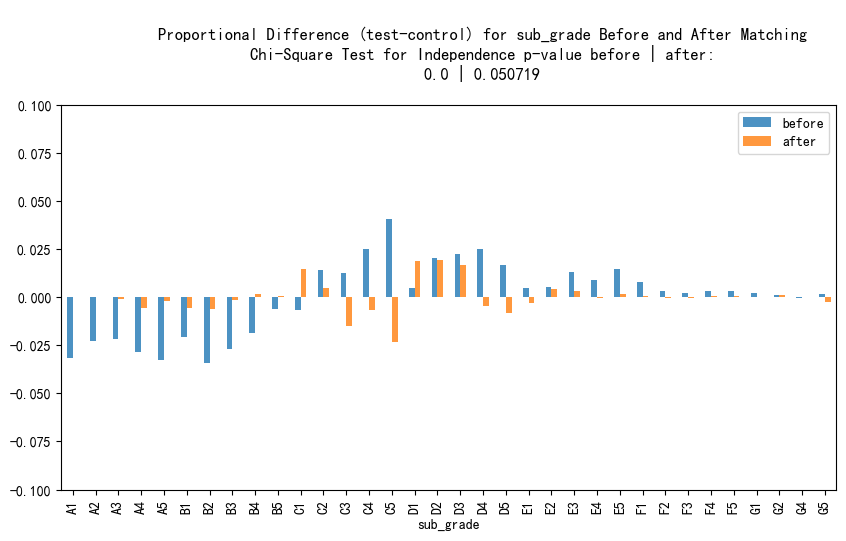

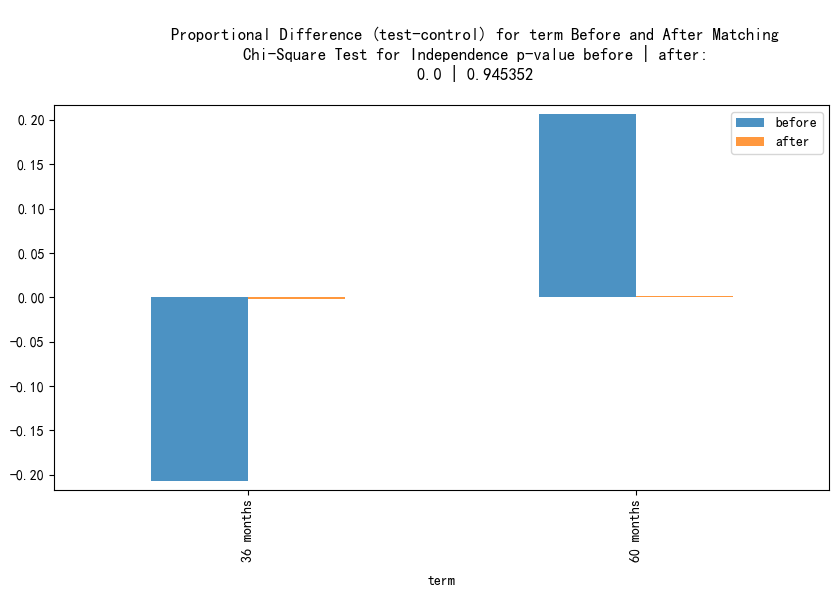

In [317]:
# 倾向性得分前后匹配后 - 离散特征的卡方分布变化
categorical_results = m.compare_categorical(return_table=True)

In [318]:
categorical_results['是否通过'] = categorical_results['after'] > 0.05
categorical_results

,var,before,after,是否通过
0,grade,0.0,0.054553,True
1,sub_grade,0.0,0.050719,True
2,term,0.0,0.945352,True


Looking at the plots and test results, we did a pretty good job balancing our categorical features! The p-values from the Chi-Square tests are all > 0.05 and we can verify by observing the small proportional differences in the plots.

___Continuous___

For continous variables we look at Empirical Cumulative Distribution Functions (ECDF) for our test and control groups  before and after matching.

For example, the first plot pair shows:
* ECDF for test vs ECDF for control before matching (left), ECDF for test vs ECDF for control after matching(right). We want the two lines to be very close to each other (or indistiguishable) after matching.
* Some tests + metrics are included in the chart titles.
    * Tests performed:
        * Kolmogorov-Smirnov Goodness of fit Test (KS-test)
            This test statistic is calculated on 1000
            permuted samples of the data, generating
            an imperical p-value.  See pymatch.functions.ks_boot()
            This is an adaptation of the ks.boot() method in 
            the R "Matching" package
            https://www.rdocumentation.org/packages/Matching/versions/4.9-2/topics/ks.boot
        * Chi-Square Distance:
            Similarly this distance metric is calculated on 
            1000 permuted samples. 
            See pymatch.functions.grouped_permutation_test()

    * Other included Stats:
        * Standarized mean and median differences.
             How many standard deviations away are the mean/median
            between our groups before and after matching
            i.e. `abs(mean(control) - mean(test))` / `std(control.union(test))`

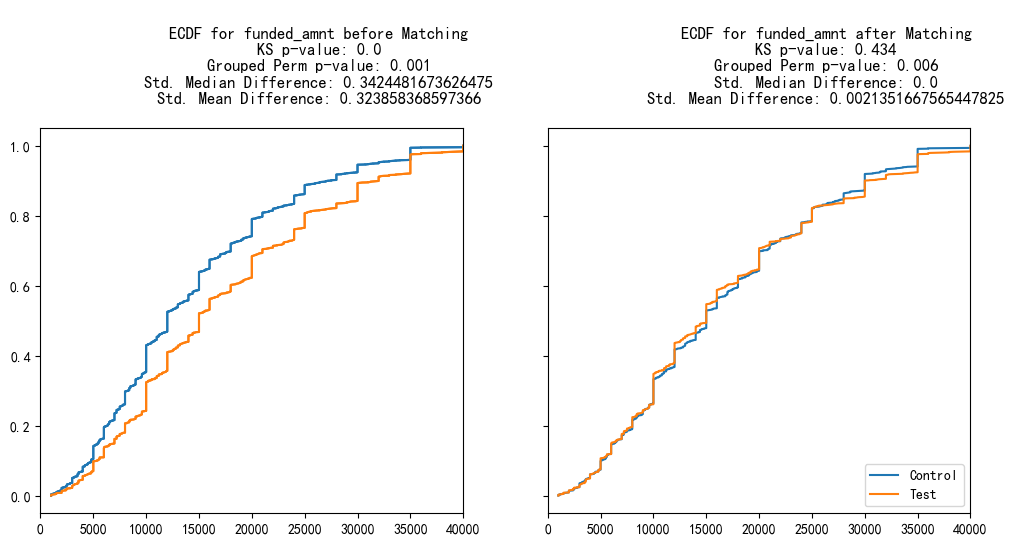

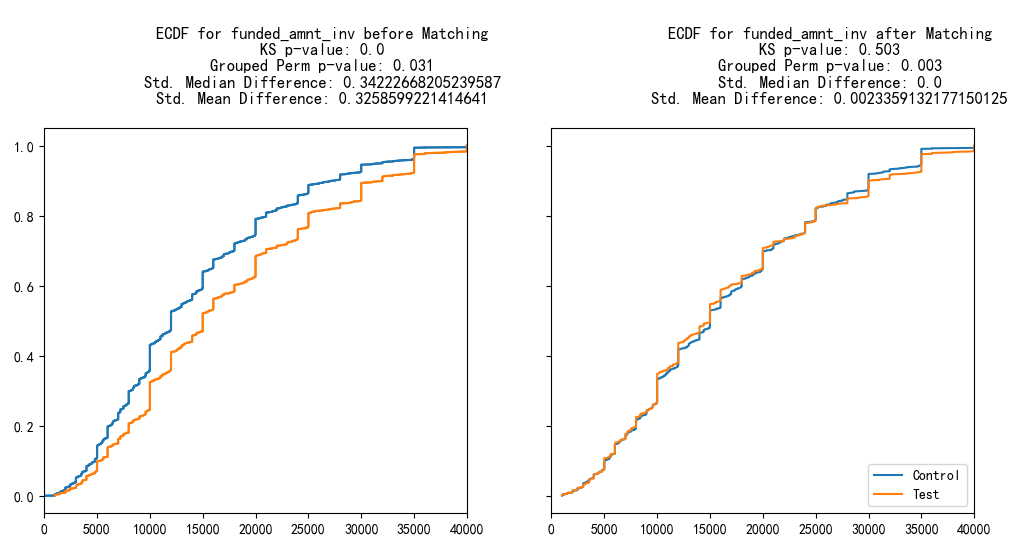

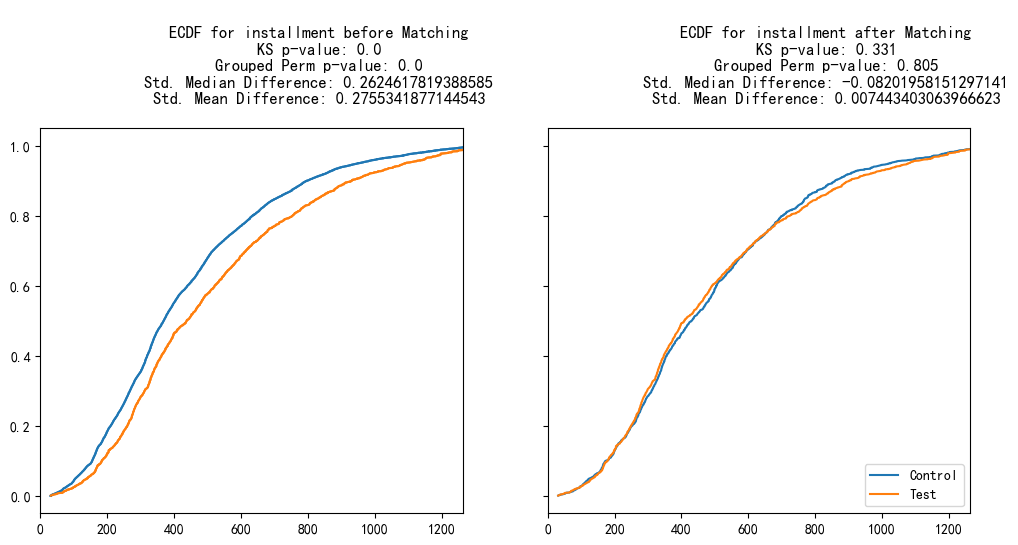

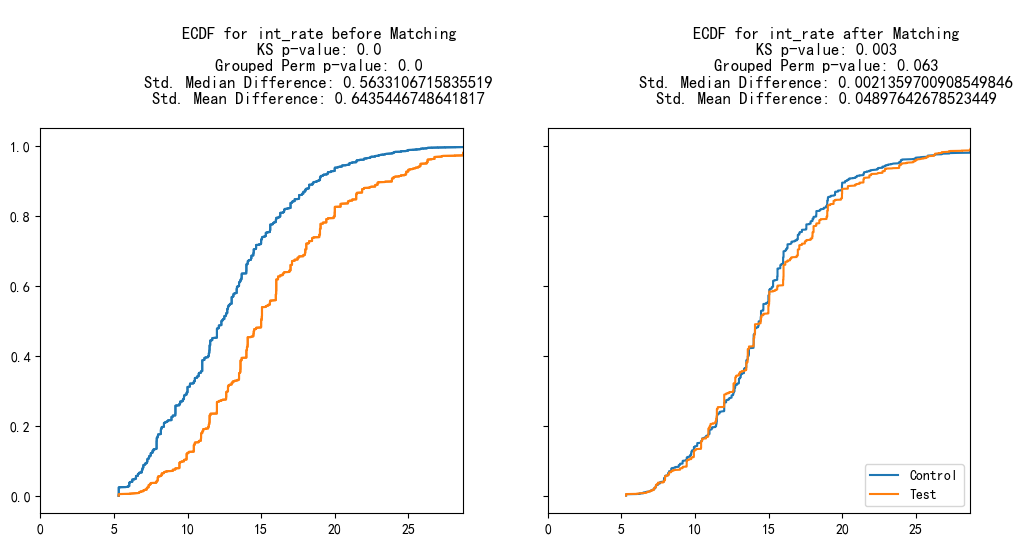

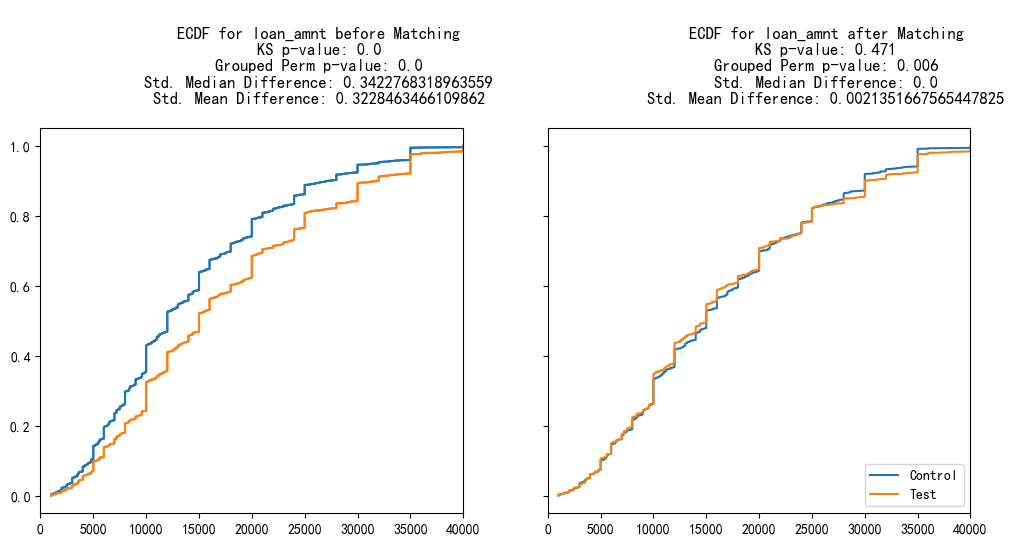

In [319]:
cc = m.compare_continuous(return_table=True)

In [320]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,funded_amnt,0.0,0.434,0.001,0.006,0.342448,0.000000,0.323858,0.002135
1,funded_amnt_inv,0.0,0.503,0.031,0.003,0.342227,0.000000,0.325860,0.002336
2,installment,0.0,0.331,0.000,0.805,0.262462,-0.082020,0.275534,0.007443
3,int_rate,0.0,0.003,0.000,0.063,0.563311,0.002136,0.643545,0.048976
4,loan_amnt,0.0,0.471,0.000,0.006,0.342277,0.000000,0.322846,0.002135


In [321]:
cc['是否通过'] = (cc['ks_after'] > 0.05) | (cc['grouped_chisqr_after'] > 0.05)

In [322]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after,是否通过
0,funded_amnt,0.0,0.434,0.001,0.006,0.342448,0.000000,0.323858,0.002135,True
1,funded_amnt_inv,0.0,0.503,0.031,0.003,0.342227,0.000000,0.325860,0.002336,True
2,installment,0.0,0.331,0.000,0.805,0.262462,-0.082020,0.275534,0.007443,True
3,int_rate,0.0,0.003,0.000,0.063,0.563311,0.002136,0.643545,0.048976,True
4,loan_amnt,0.0,0.471,0.000,0.006,0.342277,0.000000,0.322846,0.002135,True


We want the pvalues from both the KS-test and the grouped permutation of the Chi-Square distance after matching to be > 0.05, and they all are! We can verify by looking at how close the ECDFs are between test and control.

# Conclusion

We saw a very "clean" result from the above procedure, achieving balance among all the covariates. In my work at Mozilla, we see much hairier results using the same procedure, which will likely be your experience too. In the case that certain covariates are not well balanced, one might consider tinkering with the parameters of the matching process (`nmatches`>1) or adding more covariates to the formula specified when we initialized the `Matcher` object.
In any case, in subsequent modelling, you can always control for variables that you haven't deemed "balanced".